<a href="https://colab.research.google.com/github/Arun-Pat/MLZoomCamp_AP/blob/main/MLZoomCamp_HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework**
Note: sometimes your answer doesn't match one of the options exactly. That's fine. Select the option that's closest to your solution.

Dataset
In this homework, we will use the California Housing Prices from Kaggle.

Here's a wget-able link:

wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

# import re

%matplotlib inline

In [ ]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'
!wget $url
df = pd.read_csv('housing.csv')
df.head(3)

--2023-10-20 15:38:00--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]   1.36M  --.-KB/s    in 0.05s   

2023-10-20 15:38:01 (29.5 MB/s) - ‘housing.csv.1’ saved [1423529/1423529]



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


# **Preparing the dataset**
For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2 we are going to use all columns of the dataset.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Preparation:

- Fill missing values with zeros.
- Apply the log tranform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [ ]:
df_orig = df.copy()
# keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df = df[(df.ocean_proximity=='<1H OCEAN') |  (df.ocean_proximity == 'INLAND')]
df = df.fillna(0) # Fill missing values with zeros.

In [ ]:
# Do train/validation/test split with 60%/20%/20% distribution.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

# len(df),len(df_full_train),len(df_train),len(df_val),len(df_test)
all_features = list(df_train.columns)
all_features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity']

In [ ]:
# IMPLEMENTATION OF DICTVECTORIZER to convert into Matrix form
# All features to be used. So not mentioning specifically
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
# X_val.get_shape()

# **Question 1**
Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.
Which feature is used for splitting the data?

- ocean_proximity  ✅
- total_rooms
- latitude
- population

In [ ]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=1)

In [ ]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



# **Question 2**
Train a random forest model with these parameters:

n_estimators=10
random_state=1
n_jobs=-1 (optional - to make training faster)
What's the RMSE of this model on validation?

- 0.045
- 0.245 ✅
- 0.545
- 0.845

In [ ]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val,y_pred))

0.24495290030597153

# **Question 3**
Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.
After which value of n_estimators does RMSE stop improving?

- 10
- 25
- 50
- 160 ✅

In [ ]:
# scores = []

# for n in tqdm(range(10, 201, 10)):
#     rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
#     rf.fit(X_train, y_train)

#     y_pred = rf.predict(X_val)
#     score = np.sqrt(mean_squared_error(y_val, y_pred))

#     scores.append((n, score))

# df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])


In [ ]:
# df_scores.head(3)

In [ ]:
# plt.grid(True)
# plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
# plt.show()



In [ ]:
# ALternate and Faster Way where the model is not recreated but only tuned after changing n_estimators value
scores = []

rf = RandomForestRegressor(n_estimators=0,
                           random_state=1, n_jobs=-1,
                           warm_start=True)

for n in tqdm(range(10, 201, 10)):
    rf.n_estimators = n
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))

    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

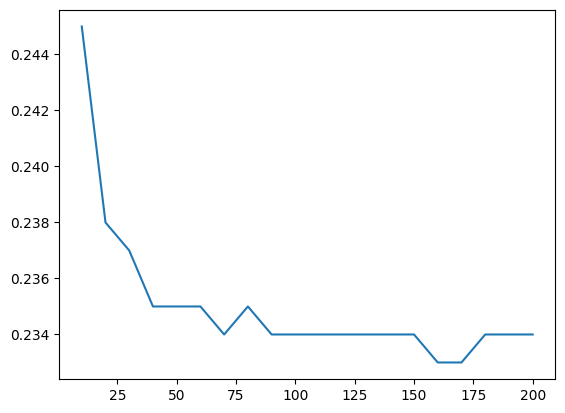

In [ ]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

# **Question 4**
Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values,
  - try different values of n_estimators from 10 till 200 (with step 10)
  - calculate the mean RMSE
- Fix the random seed: random_state=1

What's the best max_depth, using the mean RMSE?

- 10
- 15
- 20
- 25 ✅

In [ ]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# calculate the mean RMSE
for md in df_scores.max_depth.unique():
  print(f'max_depth: {md}    mean rmse:{df_scores[df_scores.max_depth==md].rmse.mean()}')

max_depth: 10    mean rmse:0.24544051287746918
max_depth: 15    mean rmse:0.23593809323441647
max_depth: 20    mean rmse:0.23528368743179717
max_depth: 25    mean rmse:0.2348961369222931


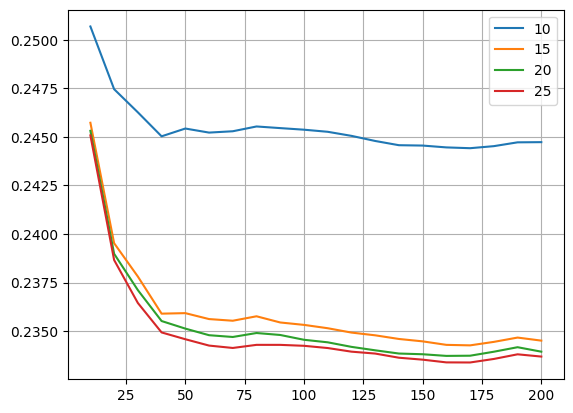

In [ ]:
plt.grid(True)
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

# **Question 5**
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

- Train the model with these parameters:
  - n_estimators=10,
  - max_depth=20,
  - random_state=1,
  - n_jobs=-1 (optional)
- Get the feature importance information from this model





What's the most important feature (among these 4)?

- total_rooms
- median_income ✅
- total_bedrooms
- longitude

In [ ]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20,
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [ ]:
rf.feature_importances_

array([0.01495348, 0.03019435, 0.10189142, 0.0861758 , 0.33566849,
       0.29247297, 0.07380644, 0.02682069, 0.01624481, 0.02177155])

In [ ]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False)

,feature,importance
4,median_income,0.335668
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.101891
3,longitude,0.086176
6,ocean_proximity=INLAND,0.073806
1,housing_median_age,0.030194
7,population,0.026821
9,total_rooms,0.021772
8,total_bedrooms,0.016245
0,households,0.014953


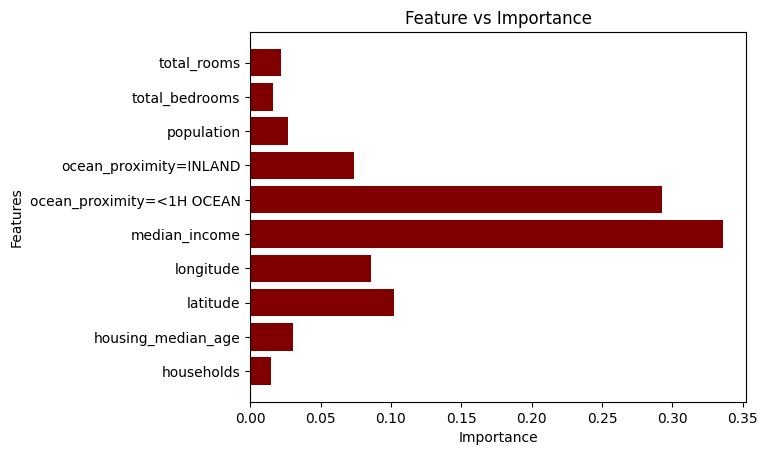

In [ ]:
# creating the bar plot
plt.barh(df_importances['feature'], df_importances['importance'], color ='maroon')
        # width = 0.4)

plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature vs Importance")

plt.show()

# **Question 6**
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {

    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

- 0.3  ✅
- 0.1
- Both give equal value

In [ ]:
features = dv.feature_names_
features = [string.replace('<', '_').replace('[', '_').replace(']', '_') for string in features]
# regex = re.compile(r"<", re.IGNORECASE)
# features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)


In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
xgb_params = {
    # 'eval_metric':'auc',
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,

}


In [ ]:
eval_dict = {}
scores ={}
rounds = 100
model = xgb.train(xgb_params, dtrain, num_boost_round=rounds,
                  verbose_eval=5,
                  evals=watchlist, evals_result=eval_dict)

[0]	train-rmse:0.44350	val-rmse:0.44250
[5]	train-rmse:0.25338	val-rmse:0.27463
[10]	train-rmse:0.21444	val-rmse:0.25179
[15]	train-rmse:0.19858	val-rmse:0.24522
[20]	train-rmse:0.18524	val-rmse:0.23978
[25]	train-rmse:0.17757	val-rmse:0.23830
[30]	train-rmse:0.16888	val-rmse:0.23570
[35]	train-rmse:0.16113	val-rmse:0.23416
[40]	train-rmse:0.15542	val-rmse:0.23318
[45]	train-rmse:0.14941	val-rmse:0.23190
[50]	train-rmse:0.14536	val-rmse:0.23225
[55]	train-rmse:0.14150	val-rmse:0.23197
[60]	train-rmse:0.13719	val-rmse:0.23139
[65]	train-rmse:0.13259	val-rmse:0.23158
[70]	train-rmse:0.12943	val-rmse:0.23068
[75]	train-rmse:0.12555	val-rmse:0.23039
[80]	train-rmse:0.12192	val-rmse:0.22886
[85]	train-rmse:0.11854	val-rmse:0.22888
[90]	train-rmse:0.11496	val-rmse:0.22861
[95]	train-rmse:0.11211	val-rmse:0.22908
[99]	train-rmse:0.10989	val-rmse:0.22862


In [ ]:
scores['eta=0.3'] = eval_dict.get('val').get('rmse')
min(eval_dict.get('val').get('rmse'))


0.22861380891612362

In [ ]:
xgb_params = {
    # 'eval_metric':'auc',
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,

}


In [ ]:
eval_dict = {}
model = xgb.train(xgb_params, dtrain, num_boost_round=rounds,
                  verbose_eval=5,
                  evals=watchlist, evals_result=eval_dict)

[0]	train-rmse:0.52449	val-rmse:0.52045
[5]	train-rmse:0.37822	val-rmse:0.38151
[10]	train-rmse:0.30326	val-rmse:0.31427
[15]	train-rmse:0.26538	val-rmse:0.28380
[20]	train-rmse:0.24512	val-rmse:0.26882
[25]	train-rmse:0.23026	val-rmse:0.25997
[30]	train-rmse:0.21887	val-rmse:0.25266
[35]	train-rmse:0.21020	val-rmse:0.24826
[40]	train-rmse:0.20392	val-rmse:0.24539
[45]	train-rmse:0.19814	val-rmse:0.24293
[50]	train-rmse:0.19215	val-rmse:0.24020
[55]	train-rmse:0.18809	val-rmse:0.23878
[60]	train-rmse:0.18457	val-rmse:0.23791
[65]	train-rmse:0.18063	val-rmse:0.23698
[70]	train-rmse:0.17741	val-rmse:0.23622
[75]	train-rmse:0.17468	val-rmse:0.23510
[80]	train-rmse:0.17242	val-rmse:0.23453
[85]	train-rmse:0.17014	val-rmse:0.23404
[90]	train-rmse:0.16797	val-rmse:0.23332
[95]	train-rmse:0.16562	val-rmse:0.23276
[99]	train-rmse:0.16323	val-rmse:0.23209


In [ ]:
scores['eta=0.1'] = eval_dict.get('val').get('rmse')
min(eval_dict.get('val').get('rmse'))

0.2320892516588856

In [ ]:
# range(0,rounds)
# scores['eta=0.1']

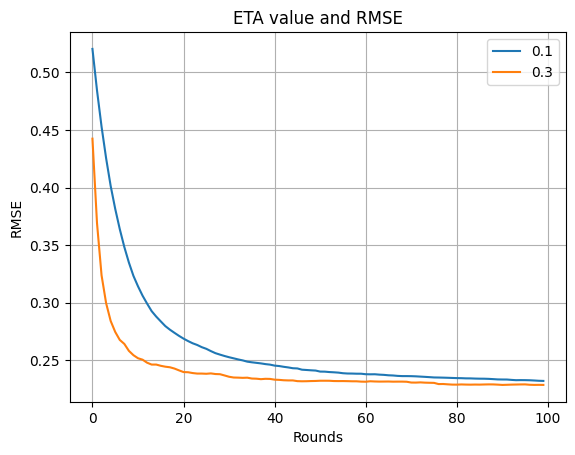

In [ ]:
plt.grid()
plt.plot(range(0,rounds), scores['eta=0.1'],label='0.1')
plt.plot(range(0,rounds), scores['eta=0.3'],label='0.3')
plt.xlabel("Rounds")
plt.ylabel("RMSE")
plt.title("ETA value and RMSE")

plt.legend()
plt.show()